# Teste de viabilidade

**Caio Geraldes, 2021**

Este notebook testa a viabilidade dos algoritmos do módulo `lexicogenero`, de minha autoria, para selecionar, dividir e organizar dados de textos em prosa em grego antigo para a disciplina FLL5133-2021.
O código fonte dos scripts utilizados aqui, bem como dos testes de qualidade estão disponíveis em meu [GitHub](https://github.com/caiogeraldes/lexico-e-genero/).

## Carregamento e organização dos dados importados do Diorisis

Pretendo utilizar o corpus anotado [Diorisis](https://figshare.com/articles/dataset/The_Diorisis_Ancient_Greek_Corpus_JSON_/12251468) de Alessandro Vatri e Barbara McGillyvray, disponível em formato `.json` e com lemmatização confiável ([Vatri, 2020](https://brill.com/view/journals/jgl/20/2/article-p179_4.xml)).
 Para processar esse corpus, utilizei as funções criadas em [../src/lexicogenero/ferramentas/diorisis_reader.py](https://github.com/caiogeraldes/lexico-e-genero/blob/main/src/lexicogenero/ferramentas/diorisis_reader.py).
 A lista de *stop words* utilizada vem de [Rodda, 2020](https://github.com/MartinaAstridRodda/dphil-thesis), com algumas adições (código em [../src/lexicogenero/grc.py](https://github.com/caiogeraldes/lexico-e-genero/blob/main/src/lexicogenero/grc.py)).

In [1]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
from lexicogenero.ferramentas.diorisis_reader import carrega_textos, em_pandas, sent_pandas
from lexicogenero.main import DIORISIS_PATH
from lexicogenero.grc import STOPS_LIST

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

Neste teste, usaremos como corpus os textos de historiografia e prosa filosófica (diálogos e tratados) de autores do período clássico:

- Historiografia:
    - Heródoto
    - Xenofonte:
        - Ciropédia
        - Anábase
        - Helênica
    - Tucídides
- Prosa filosófica:
    - Platão
    - Xenofonte:
        - Agesilau
        - Hierão
        - Simpósio
        - Apologia
        - Memorabilia

In [3]:
DATA = "data.csv"
SENTS = "sents.csv"
REAPROVEITAR = True

if not REAPROVEITAR or (DATA not in os.listdir() or SENTS not in os.listdir()):
    ignorados = [
        "Xenophon (0032) - On the Art of Horsemanship (013).json",
        "Xenophon (0032) - Economics (003).json",
        "Xenophon (0032) - Ways and Means (011).json",
        "Xenophon (0032) - Constitution of the Lacedaemonians (010).json",
        "Xenophon (0032) - On the Cavalry Commander (012).json",
        "Xenophon (0032) - On Hunting (014).json",
        "Xenophon (0032) - Apology (005).json",
    ]

    corpus = carrega_textos(autores=['Herodotus', 
                                     'Thucydides', 
                                     'Plato', 
                                     'Xenophon (0032)', # Exclui Xenofonte de Éfeso 
                                     ],
                            diorisis_path=DIORISIS_PATH,
                            ignore=ignorados,
                            verbose=False)
    df_tokens = em_pandas(corpus)
    df_sents = sent_pandas(corpus)
    del corpus
    df_tokens.to_csv(DATA, index=False)
    df_sents.to_csv(SENTS, index=False)
        
else:
    print('Carregando dataframe previamente salvo')
    df_tokens = pd.read_csv(DATA)
    df_sents = pd.read_csv(SENTS)

Carregando dataframe previamente salvo


**Formato do DF**: ainda não decidi se seria mais eficiente utilizar um data frame organizado por token ou por sentenças. A implementação de ambos é muito semelhante e pode ser vista em `../src/lexicogenero/ferramentas/diorisis_parser.py`

In [4]:
df_tokens.head()

,sent_id,location,form,lemma,POS,analyses,id,file,author,text
0,1,1.t.1,Ἡροδότου,Ἡρόδοτος,proper,masc gen sg,1,Herodotus (0016) - Histories (001).json,Herodotus,Histories
1,1,1.t.1,Ἁλικαρνησσέος,Ἁλικαρνησσεύς,proper,masc gen sg (epic ionic),2,Herodotus (0016) - Histories (001).json,Herodotus,Histories
2,1,1.t.1,ἱστορίης,ἱστορία,noun,fem gen sg (epic ionic),3,Herodotus (0016) - Histories (001).json,Herodotus,Histories
3,1,1.t.1,ἀπόδεξις,ἀπόδεξις,noun,fem nom sg,4,Herodotus (0016) - Histories (001).json,Herodotus,Histories
4,1,1.t.1,ἥδε,ὅδε,pronoun,fem nom sg,5,Herodotus (0016) - Histories (001).json,Herodotus,Histories


In [5]:
df_sents.head()

,sent_id,location,forms,lemmata,file,author,text
0,1,1.t.1,"Ἡροδότου Ἁλικαρνησσέος ἱστορίης ἀπόδεξις ἥδε ,...",Ἡρόδοτος Ἁλικαρνησσεύς ἱστορία ἀπόδεξις ὅδε ὡς...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
1,2,1.1.1,Περσέων μέν νυν οἱ λόγιοι Φοίνικας αἰτίους φασ...,Πέρσευς μέν νῦν ὁ λόγιος Φοῖνιξ αἴτιος φημί γί...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
2,3,1.1.2,τούτους γὰρ ἀπὸ τῆς Ἐρυθρῆς καλεομένης θαλάσση...,οὗτος γάρ ἀπό ὁ Ἐρυθραί καλέω θάλασσα ἀφικνέομ...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
3,4,1.1.7,τὸ δὲ Ἄργος τοῦτον τὸν χρόνον προεῖχε ἅπασι τῶ...,ὁ δέ Ἄργος οὗτος ὁ χρόνος προέχω ἅπας ὁ ἐν ὁ ν...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
4,5,1.1.9,ἀπικομένους δὲ τούς Φοίνικας ἐς δὴ τὸ Ἄργος το...,ἀφικνέομαι δέ ὁ Φοῖνιξ εἰς δή ὁ Ἄργος οὗτος δι...,Herodotus (0016) - Histories (001).json,Herodotus,Histories


## Anotando Gênero

In [6]:
hist = [
    "Herodotus (0016) - Histories (001).json",
    "Thucydides (0003) - History (001).json",
    "Xenophon (0032) - Hellenica (001).json",
    "Xenophon (0032) - Cyropaedia (007).json",
    "Xenophon (0032) - Anabasis (006).json",
]

In [7]:
# Deve haver uma maneira menos rocambolesca para resolver isso
df_tokens['genero'] = np.nan
df_tokens.loc[df_tokens.file.isin(hist), 'genero'] = "hist"
df_tokens.genero.fillna("filo", inplace=True)
df_sents['genero'] = np.nan
df_sents.loc[df_sents.file.isin(hist), 'genero'] = "hist"
df_sents.genero.fillna("filo", inplace=True)

Para meu modelo funcionar, será necessário ter uma quantidade relativamente equilibrada de dados entre autores de prosa historiográfica e prosa filosófica, a seleção parece razoável.
Qualquer tentativa de aumentar os dados de historiografia forçaria aumentar o escopo temporal (o próximo autor seria Políbio, já do período helenístico).
Nota-se que a diferença aumenta quando tratamos de sentenças e não de tokens, indicando que as sentenças em textos historiográficos devem ser um pouco mais longas na média.

<AxesSubplot:>

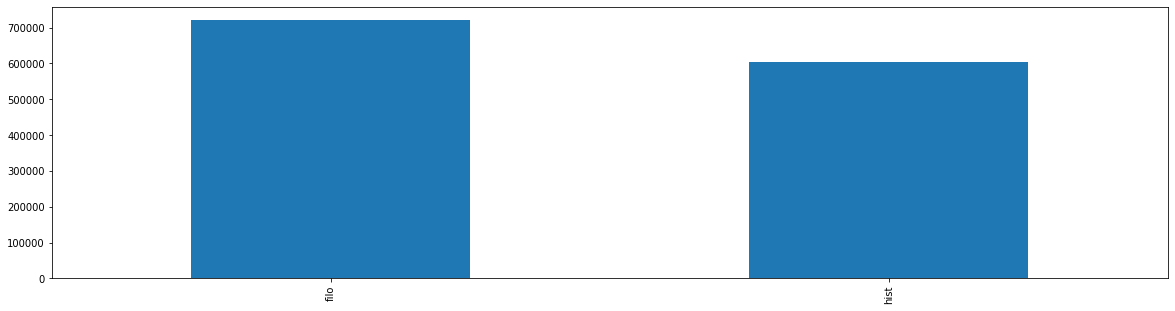

In [8]:
df_tokens.genero.value_counts().plot(kind='bar')

<AxesSubplot:>

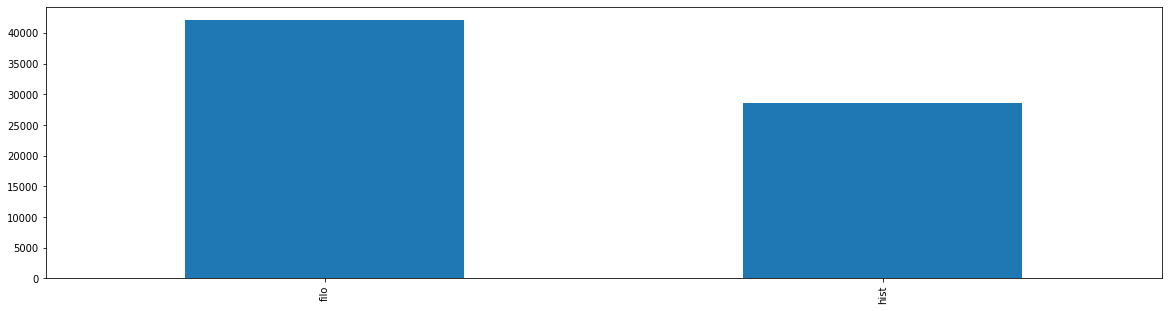

In [9]:
df_sents.genero.value_counts().plot(kind='bar')

## Verbos por gênero (dataframe de tokens)

In [10]:
df_verbos = df_tokens.loc[(df_tokens.POS == "verb") & (-df_tokens.lemma.isin(STOPS_LIST))]
df_verbos.head()

,sent_id,location,form,lemma,POS,analyses,id,file,author,text,genero
30,1,1.t.1,ἀποδεχθέντα,ἀποδέχομαι,verb,aor part pass neut nom/voc/acc pl;aor part pas...,28,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
42,1,1.t.1,ἐπολέμησαν,πολεμέω,verb,aor ind act 3rd pl,38,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
62,3,1.1.2,καλεομένης,καλέω,verb,fut part mid fem gen sg (attic epic ionic);pre...,6,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
64,3,1.1.2,ἀπικομένους,ἀφικνέομαι,verb,aor part mid masc acc pl (ionic),8,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
71,3,1.1.2,οἰκήσαντας,οἰκέω,verb,aor part act masc acc pl,14,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist


A filtragem não causa mudança na proporção entre documentos de historiografia e filosofia.

<AxesSubplot:>

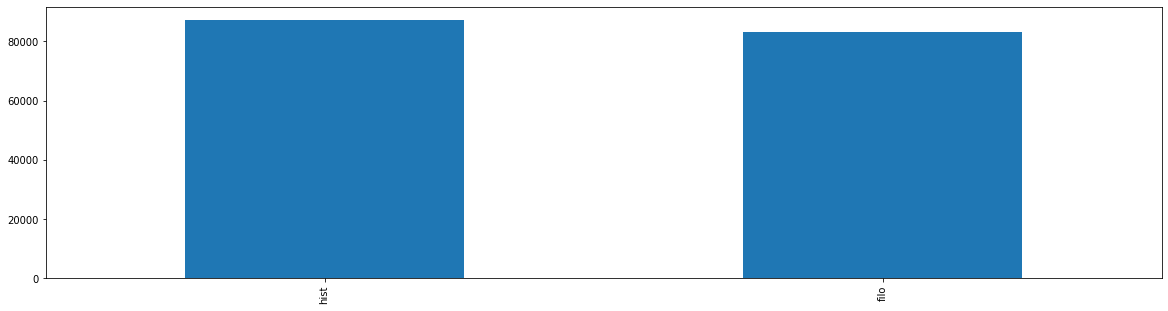

In [11]:
df_verbos.genero.value_counts().plot(kind='bar')

In [12]:
filo_verbos = df_verbos[df_verbos.genero == "filo"].lemma
filo_verbos.value_counts()

οἴομαι           1767
οἶδα             1482
φαίνω            1204
βούλομαι         1177
δεῖ              1026
                 ... 
προπαιδεύω          1
μολύνω              1
διαίνω              1
ὑπεραγανακτέω       1
ἐφέζομαι            1
Name: lemma, Length: 3663, dtype: int64

<AxesSubplot:ylabel='Density'>

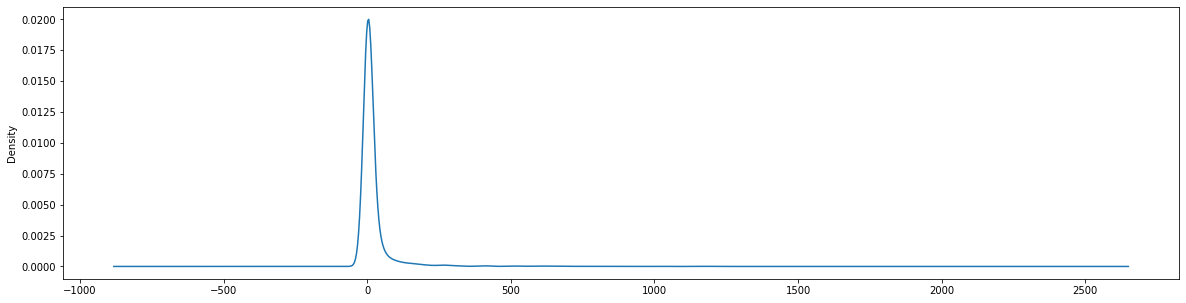

In [13]:
filo_verbos.value_counts().plot(kind='density')

In [14]:
hist_verbos = df_verbos[df_verbos.genero == "hist"].lemma
hist_verbos.value_counts()

βούλομαι        1177
λαμβάνω          994
ἀφικνέομαι       915
ἔρχομαι          872
πάρειμι          822
                ... 
ἐπεικάζω           1
ἀποκηδεύω          1
πυκνόω             1
καθιππάζομαι       1
ἐξαυλίζομαι        1
Name: lemma, Length: 4331, dtype: int64

<AxesSubplot:ylabel='Density'>

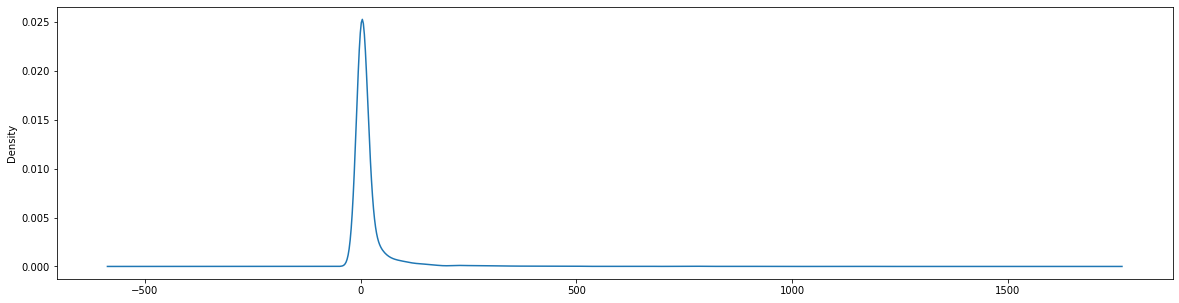

In [15]:
hist_verbos.value_counts().plot(kind='density')

## Naive Bayes


### Apenas de tokens

O resultado é terrível, provavelmente porque a implementação do modelo não é a melhor, afinal o `DOCUMENTO` e suas componentes são a mesma entidade.

In [16]:
x, y = df_verbos.lemma, df_verbos.genero

In [17]:

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20, random_state=42)

filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

In [18]:
vocab_filo = Counter(filo)
vocab_hist = Counter(hist)

In [19]:
n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

In [20]:
n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

In [21]:
def bayes(texto):
    
    texto_filo = [x for x in texto if x in vocab_filo.keys()]
    c_doc_filo = Counter(texto_filo)
    texto_hist = [x for x in texto if x in vocab_hist.keys()]
    c_doc_hist = Counter(texto_hist)
    
    pf_filo = sum([np.log2((c_doc_filo[token] + 1) / n_vocab_filo + len(texto_filo)) for token in texto_filo])
    pf_hist = sum([np.log2((c_doc_hist[token] + 1) / n_vocab_hist + len(texto_hist)) for token in texto_hist])

    
    prob_filo = p_filo + pf_filo
    prob_hist = p_hist + pf_hist


    return prob_filo, prob_hist

In [22]:
teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

In [23]:
teste_orig_labels = [x for x in y_teste]

performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")
        
perf_counter = Counter(performance_labels)

In [24]:
perf_counter

Counter({'VN': 17407, 'FP': 16718})

### Com sentenças

O modelo assim performa melhor, mas é pouco específico para os meus interesses: que o vocabulário da prosa filosófica e historiográfica são distintos diz pouco sobre sua seleção de verbos.

In [25]:
def achatar(lista):
    return list(itertools.chain(*lista))

df_sents['lst_lemmata'] = df_sents.lemmata.str.split()
df_sents.dropna(inplace=True)

In [26]:
x, y = df_sents.lst_lemmata, df_sents.genero

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20, random_state=42)

In [27]:
filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']

vocab_filo = Counter([x for x in achatar(filo)])
vocab_hist = Counter([x for x in achatar(hist)])

n_filo = len(filo)
n_hist = len(hist)
n = n_filo + n_hist
p_filo = np.log2(n_filo / n)
p_hist = np.log2(n_hist / n)

n_vocab_filo = len(vocab_filo)
n_vocab_hist = len(vocab_hist)

In [28]:
def bayes(texto):
    
    texto_filo = [x for x in texto if x in vocab_filo.keys()]
    c_doc_filo = Counter(texto_filo)
    texto_hist = [x for x in texto if x in vocab_hist.keys()]
    c_doc_hist = Counter(texto_hist)
    
    pf_filo = sum([np.log2((c_doc_filo[token] + 1) / n_vocab_filo + len(texto_filo)) for token in texto_filo])
    pf_hist = sum([np.log2((c_doc_hist[token] + 1) / n_vocab_hist + len(texto_hist)) for token in texto_hist])

    
    prob_filo = p_filo + pf_filo
    prob_hist = p_hist + pf_hist


    return prob_filo, prob_hist

In [29]:
teste_pred_labels = []
for t in x_teste:
    prob_filo, prob_hist = bayes(t)
    if prob_filo >= prob_hist:
        teste_pred_labels.append("filo")
    else:
        teste_pred_labels.append("hist")

teste_orig_labels = [x for x in y_teste]

In [30]:
performance_labels = []

for pred, label in zip(teste_pred_labels, teste_orig_labels):
    if label == "filo" and pred == "filo":
        performance_labels.append("VP")
    elif label == "filo" and pred == "hist":
        performance_labels.append("FP")
    elif label == "hist" and pred == "hist":
        performance_labels.append("VN")
    else:
        performance_labels.append("FN")

In [31]:
perf_counter = Counter(performance_labels)

perf_counter

Counter({'VP': 8254, 'VN': 2678, 'FN': 3046, 'FP': 165})

In [32]:
precisao = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FP'])
cobertura = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FN'])
acuracia = (perf_counter['VP'] + perf_counter['VN']) / len(performance_labels)
medida_f = 2 * (precisao * cobertura) / (precisao + cobertura)

print(f'Precisão:  {precisao}')
print(f'Cobertura: {cobertura}')
print(f'Acurácia:  {acuracia}')
print(f'Medida F:  {medida_f}')

Precisão:  0.9804014728590094
Cobertura: 0.7304424778761062
Acurácia:  0.7729618892738457
Medida F:  0.8371621278969521


# Conclusões

- O banco de dados anotado Diorisis oferece as anotações necessárias e é relativamente fácil de processar.
- O corpus proposto oferece um número relativamente equilibrado de dados para as categorias a serem classificadas e o algoritmo de processamento permite que ele seja expandido conforme necessário.
- Será importante revisar a suavização utilizada (no caso Laplace) para poder obter um modelo funcional se for utilizado um modelo como o Naive Bayes apenas com os verbos, embora a princípio já seja possível afirmar que esse modelo não funcionará bem assim.
- Se for possível codificar a informação de `df_sents.lst_lemmata` selecionar os verbos principais (utilizando o dependency parser do `stanza-perseus`), os resultados poderão ser mais consistentes com aqueles que são de meu interesse.